In [5]:
import cv2
import mediapipe as mp
import numpy as np
import time

In [6]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

In [8]:
import csv
import os

# Directory to save CSV files
output_dir = './data/test'
os.makedirs(output_dir, exist_ok=True)

gesture_action = "WAVING"

# Function to record hand landmarks
def record_hand_landmarks():
    cap = cv2.VideoCapture(0)
    recording = False
    landmarks_seq = []

    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        frame = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                if recording:
                    # Extract landmarks
                    landmarks = [lm for lm in hand_landmarks.landmark]
                    landmarks_flat = [coord for lm in landmarks for coord in (lm.x, lm.y, lm.z)]
                    landmarks_seq.append(landmarks_flat)

        cv2.imshow('Hand Gesture Recording', frame)

        key = cv2.waitKey(5) & 0xFF
        if key == ord('r'):
            recording = True
            landmarks_seq = []  # Start a new recording
            print("Recording started...")
        elif key == ord('s'):
            recording = False
            print("Recording stopped.")
            if landmarks_seq:
                # Save to CSV
                gesture_name = gesture_action
                current_time = int(time.time())

                output_file = os.path.join(output_dir, f'{gesture_name}_{current_time}.csv')
                with open(output_file, 'w', newline='') as f:
                    writer = csv.writer(f)
                    # header 
                    header = ['frame'] + [f'{coord}_{i}' for i in range(21) for coord in ('x', 'y', 'z')] + ['frame_rate', 'frame_width', 'frame_height']
                    writer.writerow(header)

                    # write data
                    for i, frame_data in enumerate(landmarks_seq):
                        writer.writerow([i] + frame_data + [frame_rate, frame_width, frame_height])
                        
                print(f"Saved {len(landmarks_seq)} frames to {output_file}")
        elif (key == 27) or (key == ord('q')):  # ESC key to exit
            break

    cap.release()
    cv2.destroyAllWindows()

record_hand_landmarks()

Recording started...
Recording stopped.
Saved 47 frames to ./data/test\WAVING_1719272972.csv


In [9]:
import pandas as pd 
import os 
from sklearn.preprocessing import StandardScaler


# aggergate the csv files to 1


# input_dir = "./data/dataset4"
input_dir = "./data/test"

data_frames = []
gesture_index = 0


for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_dir, file_name)
        df = pd.read_csv(file_path)
        
        # Extract gesture action and index from the file name
        gesture_action = file_name.split("_")[0]
        gesture_index = int(file_name.split("_")[1].split(".")[0])

        # Add gesture action and index to the DataFrame
        df['gesture'] = gesture_action
        df['gesture_index'] = gesture_index
        
        df.sort_values(by="frame", inplace=True)
        
        data_frames.append(df)

        
 

# combine all dataframes
all_data = pd.concat(data_frames, ignore_index=True)
grouped_data = all_data.groupby(['gesture_index', 'frame'])

# Normalize the landmark coordinates (excluding frame, gesture, frame_rate, frame_width, frame_height)
landmark_cols = [col for col in all_data.columns if col not in ['frame', 'gesture', 'frame_rate', 'frame_width', 'frame_height']]
scaler = StandardScaler()
all_data[landmark_cols] = scaler.fit_transform(all_data[landmark_cols])

# Feature Engineering: Example - Calculating distances between specific points
# Example: distance between point 0 and point 1
all_data['distance_0_1'] = ((all_data['x_0'] - all_data['x_1'])**2 + 
                            (all_data['y_0'] - all_data['y_1'])**2 + 
                            (all_data['z_0'] - all_data['z_1'])**2) ** 0.5



# Save the combined and processed DataFrame to a new CSV file
# output_file = './data/combined_dataset.csv'
output_file = './data/test1.csv'
all_data.to_csv(output_file, index=False)
print(f"Combined dataset saved to {output_file}")




Combined dataset saved to ./data/test1.csv


In [19]:
from sklearn.model_selection import train_test_split
from keras import layers, models
import pandas as pd

# trying to reshape the data into a temporal model
# reshaping using LSTM model 

input_dataframe = pd.read_csv("data/combined_dataset.csv")
features = [col for col in input_dataframe.columns if col not in ["frame", "gesture"]]

X = input_dataframe[features].values
y, class_labels = pd.factorize(input_dataframe['gesture'])

# Reshape X for LSTM input (samples, timesteps, features)
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)



model = models.Sequential([
    layers.LSTM(128, input_shape=(1, len(features))),
    layers.Dense(len(class_labels), activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test Accuracy: {test_acc}')


# model.save("data/saved_mode.h5")







Epoch 1/10


c:\Users\Gen3r\Documents\capstone\ml_model\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5999 - loss: 0.6673 - val_accuracy: 0.4868 - val_loss: 0.6561
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6123 - loss: 0.6077 - val_accuracy: 0.7105 - val_loss: 0.5851
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8305 - loss: 0.5557 - val_accuracy: 0.6974 - val_loss: 0.5456
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8895 - loss: 0.4955 - val_accuracy: 0.8553 - val_loss: 0.4782
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9350 - loss: 0.4240 - val_accuracy: 0.8684 - val_loss: 0.4387
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9565 - loss: 0.3856 - val_accuracy: 0.8947 - val_loss: 0.3886
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9609 - loss: 0.3408 - val_accuracy: 0.9079 - val_loss: 0.3443
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9606 - loss: 0.3184 - val_accuracy: 0.8947 - val_loss: 0.3393
E

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


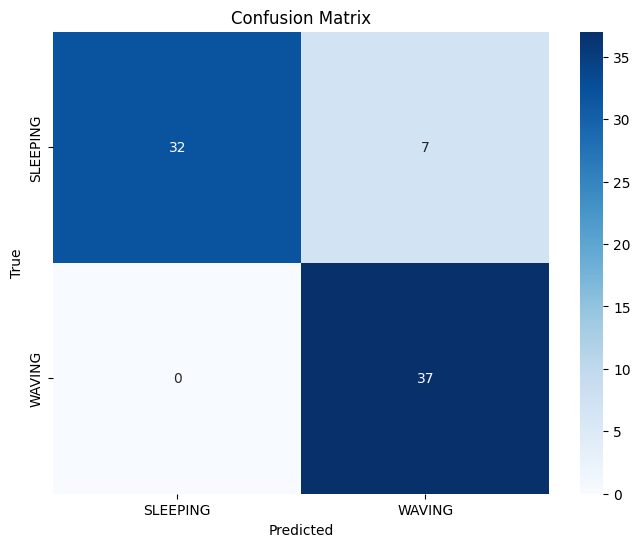

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# testing/evaluation
# Predict probabilities using the model on validation set
y_pred_probs = model.predict(X_val)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=range(len(class_labels)))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# save the class labels
# Convert to DataFrame and save to CSV
class_labels_df = pd.DataFrame({'gesture': class_labels})
class_labels_df.to_csv('data/class_labels.csv', index=False)

print("Class labels saved successfully.")

Class labels saved successfully.


In [ ]:
import matplotlib.pyplot as plt

# # Plot training & validation accuracy values
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

new_data = pd.read_csv("data/test1.csv")


# Assuming 'frame' and 'gesture' columns are not in the new data
features = [col for col in new_data.columns if col not in ['frame', 'gesture']]

# Reshape for LSTM input (samples, timesteps, features)
X_new = new_data[features].values.reshape((new_data.shape[0], 1, len(features)))


predictions = model.predict(X_new)
predicted_labels = [class_labels[np.argmax(pred)] for pred in predictions]
print(predicted_labels)



# confusion matrix to see if model is making errors
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(len(predicted_labels))
ground_truth_labels = ['WAVING'] * 47

# Generate confusion matrix
cm = confusion_matrix(ground_truth_labels, predicted_labels, labels=class_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()